In [57]:
import numpy as np
import pickle
from collections import defaultdict
from PIL import Image

# TF-IDF

In this part, we will explore the law texts from the laws that were passed and see if we can find some interesting words that defines the different parties, periods and categories of laws.

Table of contents:

* [Load Pickle File](#load-pickle-file-with-laws)
* [Get majority vote for party](#get-majority-vote-for-party)
* [TF-IDF for Parties](#tf-idf-for-parties)
* [Periods](#periods)
* [Environment category over periods](#environment-over-periods)


## Load pickle file with laws <a class="anchor" id="load-pickle-file-with-laws"></a>

In [58]:
# Load pickle file
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)

In [59]:
df.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  \
0  Loven ændrer virksomhedsskatteordningens regle...          32   
1  Med loven etableres en midlertidig ordning, så...          31   
2  Loven ændrer virksomhedsskatteordningens regle...          32   
3  Med loven åbnes der mulighed for, at Region No...          32   
4  Loven indeholder bemyndigelse til, at transpor...          32   

                                      votes_adjusted afstemnings_id_pfix  \
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...                  p2   
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...                  p4   
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...                  p5   
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...                  p9   
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...                 p10   

                       law_category_id  \
0                       [33062, 33754]   
1         [62218, 34460, 33270, 33070]   
2                       [33062, 33754]   
3                       [33056, 33086]   
4  [34460, 84356, 83647, 33917, 33364]   

                                  law_category_clean  
0             [Skatter og afgifter, virksomhedsskat]  
1  [akutjob og jobpræmie til arbejdsgivere, polit...  
2             [Skatter og afgifter, virksomhedsskat]  
3            [kollektiv transport, transportpolitik]  
4  [politisk aftale, projektering af nyanlæg og h...

## Get majority vote for party <a class="anchor" id="get-majority-vote-for-party"></a>

To be able to differentiate the parties by how they vote, we needed to define a common vote for each party. To do this, we look at all the passed laws and how the members of the party voted for each law. We defined the party vote as the vote that the majority of the party voted for on each law.

We create a new column in the dataframe containing the vote for the majority of the party. These votes have the types 1 (yes-vote), 2 (no-vote), 3 (neither yes or no).

In [60]:
#First create a dict for each law that contains the majority vote for each party

#Function that returns the majority typeid for each party for a given law
def get_majority_typeid_for_party(law):
    #Create a dict with the party as key and the typeid as value
    party_typeid_dict = {}
    for vote in law:
        #If the party is not already in the dict, add it
        if vote['party'] not in party_typeid_dict:
            party_typeid_dict[vote['party']] = [vote['typeid']]
        #If the party is already in the dict, append the typeid to the list of typeids
        else:
            party_typeid_dict[vote['party']].append(vote['typeid'])
    #Create a dict with the party as key and the majority typeid as value
    party_majority_typeid_dict = {}
    for party in party_typeid_dict:
        #Get the most common typeid for each party
        party_majority_typeid_dict[party] = max(set(party_typeid_dict[party]), key=party_typeid_dict[party].count)
    return party_majority_typeid_dict

#create a new column in the votes_df_combined dataframe called majority_typeid_for_party
df['majority_party_vote'] = [get_majority_typeid_for_party(law) for law in df['votes_adjusted']]

## TF-IDF for parties <a class="anchor" id="tf-idf-for-parties"></a>

We want to investigate whether the passed laws could say something about the different parties and how they differentiate.

First, we create a dictionary with all of the text from the 'resume' of a law with the party that voted yes as a key.

In [61]:
#Function that creates a dict with all the text in 'resume' summed for each unique key in the majority_party_vote column if the key has the value 1 in the majority_party_vote (yes)
def get_text_for_party_yes(law_text_list, majority_party_vote_list):
    #Create a dict with the party as key and the text as value
    party_text_dict = {}
    for law_text, party_vote_dict in zip(law_text_list, majority_party_vote_list):
        for party in party_vote_dict:
        #If the party is not already in the dict, add it
            if party_vote_dict[party] == 1:
                if party not in party_text_dict:
                    party_text_dict[party] = law_text
                else:
                    party_text_dict[party] += law_text
    return party_text_dict

text_dict = get_text_for_party_yes(list(df['resume']), list(df['majority_party_vote']))

Then we tokenize the text to be able to work with the text word for word

In [62]:
import nltk
from nltk.tokenize import word_tokenize
stopwords_dk = nltk.corpus.stopwords.words('danish')

#The word foreslås appear for parties as the most prominent word but says very little, this is added to stopwords
stopwords_dk.append('foreslås')

# Function to tokenize text
def tokenize_dict(party_text_dict):
    tokenized_party_dict = {}
    for party in party_text_dict:
        tokenized_party_dict[party] = word_tokenize(party_text_dict[party])
    return tokenized_party_dict

law_token_dict = tokenize_dict(text_dict)

Underneath, we implement functions for calculating TF-IDF to be reused through this notebook

In [63]:
# Calculate the frequency distribution of the words in each party
#only process words, and consider all words as lower-case
def get_tf(tokenized_dict):
    freqDist_dict = {}
    for party in tokenized_dict.keys():
        freqDist_dict[party] = nltk.FreqDist(word.lower() for word in tokenized_dict[party] if word.isalpha() and word.lower() not in stopwords_dk)
    return freqDist_dict

law_tf = get_tf(law_token_dict)

def get_idf(freqDist_dict: dict):
    idf = {}

    #for each party
    for party in freqDist_dict.keys():
        #for each word in the law text of that party
        for word in freqDist_dict[party].keys():
            #if the word has not been IDF scored yet
            if word not in idf.keys():
                for freqDist in freqDist_dict.values():
                    if word in freqDist.keys():
                        #if the word is in the frequency dict of a given community, 1 to the IDF score
                        if word not in idf.keys():
                            idf[word] = 1
                        else:
                            idf[word] += 1
                #Divide the total number of communities ("documents ") with the number of communities in which the word appeared
                idf[word] = len(freqDist_dict.keys())/ idf[word]
                idf[word] = np.log2(idf[word])

    return idf

law_idf = get_idf(law_tf)

#normalize freqdist
def get_tf_norm(freqDist_dict: dict, token_dict: dict):
    tf = defaultdict()
    for party in freqDist_dict.keys():
        tf[party] = defaultdict()
        for word in freqDist_dict[party].keys():
            tf[party][word] = freqDist_dict[party][word]/len(token_dict[party])
    return tf

law_tf_norm = get_tf_norm(law_tf, law_token_dict)


# Calculate tf-idf
def get_tf_idf(tf_dict: dict, idf_dict: dict):
    tf_idf = defaultdict()
    for party in tf_dict.keys():
        tf_idf[party] = defaultdict()
        # For each word in the community, multiply the TF and IDF score
        for word in tf_dict[party].keys():
            tf_idf[party][word] = tf_dict[party][word] * idf_dict[word]
    return tf_idf

law_tf_idf = get_tf_idf(law_tf_norm, law_idf)

def law_text_to_tf_idf(text_dict):
    token_dict = tokenize_dict(text_dict)
    tf_dict = get_tf(token_dict)
    tf_idf_dict = get_tf_idf(get_tf_norm(tf_dict, token_dict), get_idf(tf_dict))
    return tf_idf_dict

def token_to_tf_idf(token_dict):
    tf_dict = get_tf(token_dict)
    tf_idf_dict = get_tf_idf(get_tf_norm(tf_dict, token_dict), get_idf(tf_dict))
    return tf_idf_dict


We then look at the top 5 words for each party according to TF. Here we can see that only analysing words from TF does not say anything unique about the party.

In [64]:
# Get the top 5 words in each party before IDF sorting
for party in sorted(law_tf.keys()):
    print(f'{party} top 5 words: {law_tf[party].most_common(5)}')

Alternativet top 5 words: [('lovforslaget', 1586), ('kan', 603), ('kraft', 536), ('folkeparti', 514), ('ved', 458)]
Dansk Folkeparti top 5 words: [('loven', 3273), ('lovforslaget', 3138), ('kan', 1917), ('folkeparti', 1550), ('ved', 1522)]
Det Konservative Folkeparti top 5 words: [('loven', 3487), ('lovforslaget', 3324), ('kan', 2043), ('ved', 1608), ('folkeparti', 1577)]
Enhedslisten top 5 words: [('loven', 2203), ('lovforslaget', 2062), ('kan', 1365), ('ved', 1081), ('kraft', 876)]
Fólkaflokkurin top 5 words: [('danske', 8), ('færøernes', 7), ('landsstyre', 7), ('kan', 7), ('færøske', 7)]
Inuit Ataqatigiit top 5 words: [('lovforslaget', 42), ('grønland', 30), ('kan', 19), ('grønlands', 18), ('loven', 18)]
Kristendemokraterne top 5 words: [('lovforslaget', 98), ('baggrund', 74), ('kan', 54), ('loven', 48), ('ved', 40)]
Liberal Alliance top 5 words: [('lovforslaget', 2576), ('loven', 2144), ('kan', 1459), ('folkeparti', 1209), ('ved', 1092)]
Ny Alliance top 5 words: [('loven', 139), ('

We then look at the top 10 words for each party according to TF-IDF, which says a little more about each party. However, there are still a lot of words that does not say much about how the parties differentiate from eachother.

In [65]:
# List the top 5 words in each party according to TF-IDF
for party in sorted(law_tf_idf.keys()):
    #round the [1] element of the tuple (the TF-IDF score) to 3 decimals
    print(f'{party} top 5 words: {[(word, round(score, 3)) for word, score in sorted(law_tf_idf[party].items(), key=lambda x: x[1], reverse=True)[:5]]}')


Alternativet top 5 words: [('folkeparti', 0.001), ('venstre', 0.001), ('liberal', 0.001), ('alliance', 0.001), ('dansk', 0.001)]
Dansk Folkeparti top 5 words: [('folkeparti', 0.001), ('dansk', 0.001), ('loven', 0.001), ('venstre', 0.001), ('del', 0.001)]
Det Konservative Folkeparti top 5 words: [('folkeparti', 0.001), ('loven', 0.001), ('venstre', 0.001), ('dansk', 0.001), ('del', 0.001)]
Enhedslisten top 5 words: [('folkeparti', 0.001), ('loven', 0.001), ('venstre', 0.001), ('dansk', 0.0), ('regler', 0.0)]
Fólkaflokkurin top 5 words: [('færøernes', 0.006), ('landsstyre', 0.006), ('sagsområder', 0.006), ('vágar', 0.005), ('ligeværdige', 0.005)]
Inuit Ataqatigiit top 5 words: [('selvstyret', 0.002), ('grønland', 0.002), ('videoafhøring', 0.001), ('arbejdsskadestyrelsens', 0.001), ('anstalt', 0.001)]
Kristendemokraterne top 5 words: [('fremgik', 0.001), ('bemærkningerne', 0.001), ('momsfrit', 0.001), ('kulturinstitutioner', 0.001), ('dansk', 0.001)]
Liberal Alliance top 5 words: [('folke

To visualize the words from the TF-IDF analysis above, we create word clouds

In [66]:
# Create a word cloud for each community
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function for creating wordclouds of party votes
def create_wordclouds(tf_idf_dict, dim):
    fig, axs = plt.subplots(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    for n, party in enumerate(tf_idf_dict.keys()):
        wordcloud = WordCloud(
                    max_font_size=50, 
                    max_words=50,
                    stopwords = stopwords_dk,
                    background_color="white",
                    collocations=False,
                    ).generate_from_frequencies(tf_idf_dict[party])
        
        # Create a subplot of the wordcloud
        ax = plt.subplot(dim[0], dim[1], n+1)
        
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(party, fontsize=30)

    fig.tight_layout()
    plt.show()

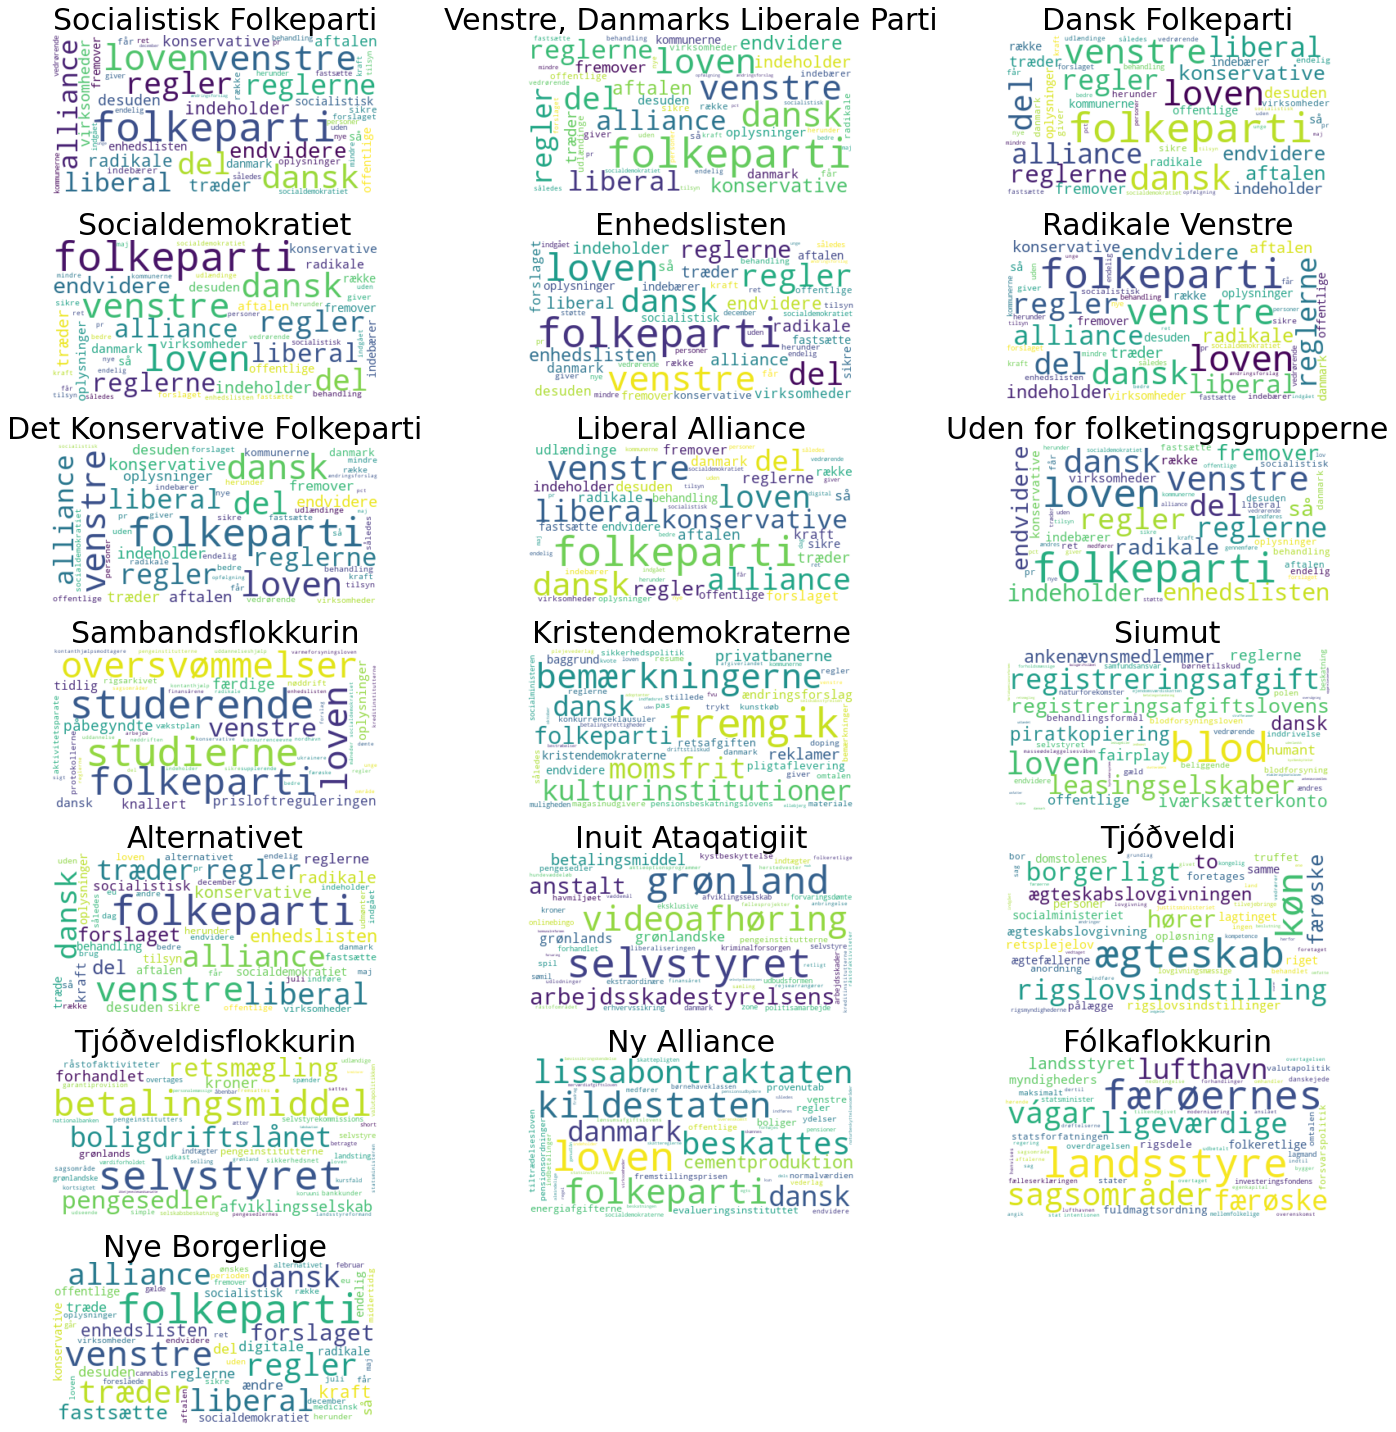

In [67]:
create_wordclouds(law_tf_idf, (7,3))

### Remove all smaller partiers to avoid a scewed TD-IDF score 

Some parties have only been part of the pariliament work for a reduced period of time, so this creates some scewed TF-IDF scores, so the words does not say much about how the parties differentiate

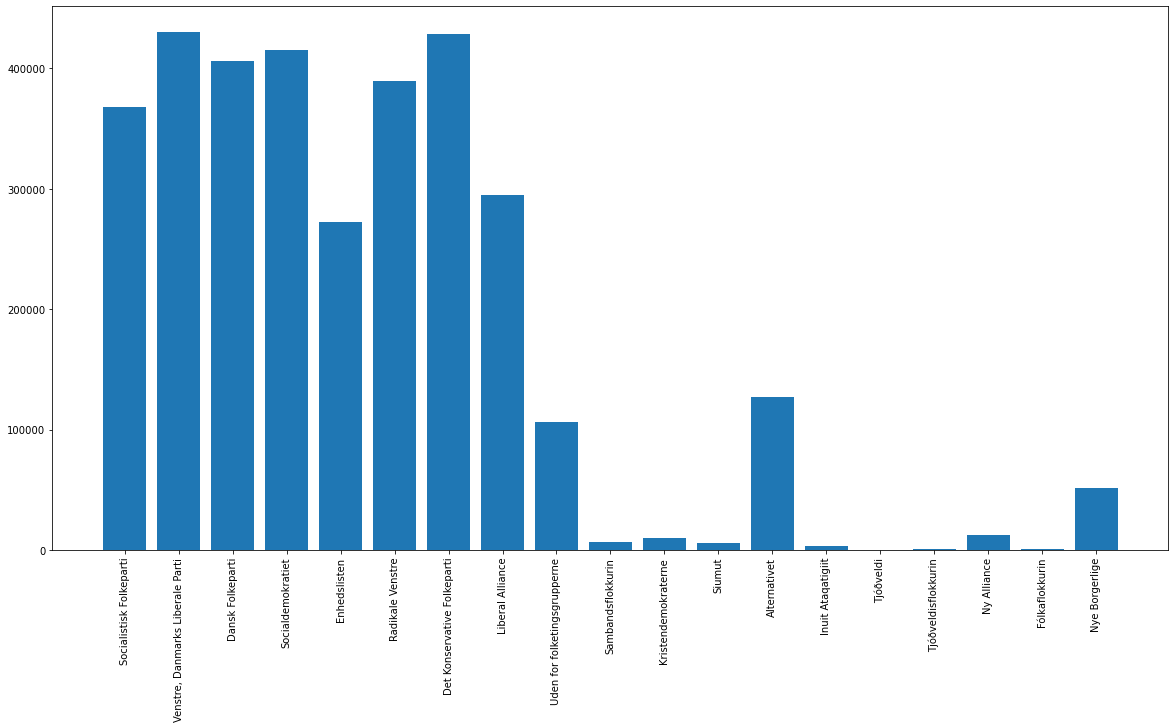

In [68]:
#plot the number of words in each party
plt.figure(figsize=(20, 10))
plt.bar(law_token_dict.keys(), [len(law_token_dict[party]) for party in law_token_dict.keys()])
plt.xticks(rotation=90)
plt.show()

In [69]:
subset_law_token = law_token_dict.copy()
small_parties =  ['Inuit Ataqatigiit', 'Tjóðveldi', 'Fólkaflokkurin', 'Tjóðveldisflokkurin', 'Uden for folketingsgrupperne', 'Sambandsflokkurin', 'Siumut', 'Ny Alliance', 'Kristendemokraterne', 'Nye Borgerlige']

#Remove list of small parties from the subset_law_token dict
for party in small_parties:
    if party in subset_law_token.keys():
        del subset_law_token[party]

In [70]:
# Create tf-idf for the subset of parties
subset_tf_idf = token_to_tf_idf(subset_law_token)

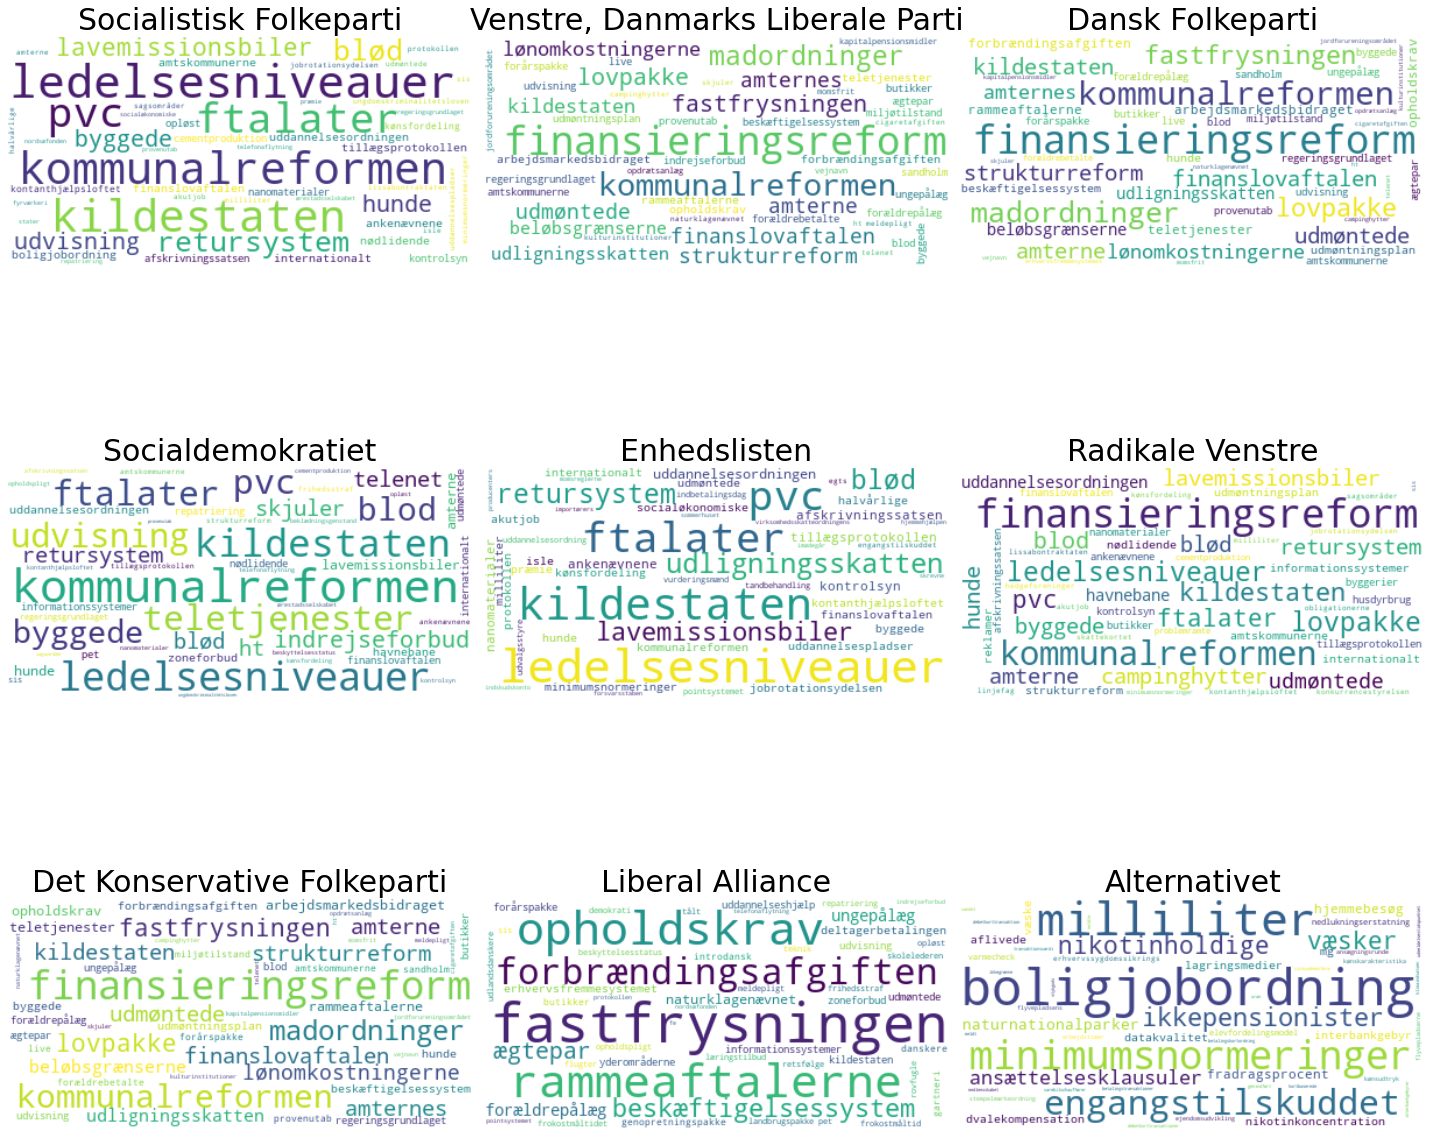

In [71]:
# Create a word cloud for each community
create_wordclouds(subset_tf_idf, (3,3))	

For the purpose of showing a word cloud in the report, we create a word cloud of enhedslisten in the shape of denmark.

In [72]:
def create_wordcloud(tf_idf_dict, title, colormap):
    wordcloud = WordCloud(
                scale=5,
                mask=np.array(Image.open('denmark_map.png')),
                max_font_size=50, 
                max_words=100,
                stopwords = stopwords_dk,
                colormap=colormap,
                background_color="white",
                collocations=False,
                ).generate_from_frequencies(tf_idf_dict)
    
    # Display the generated image
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

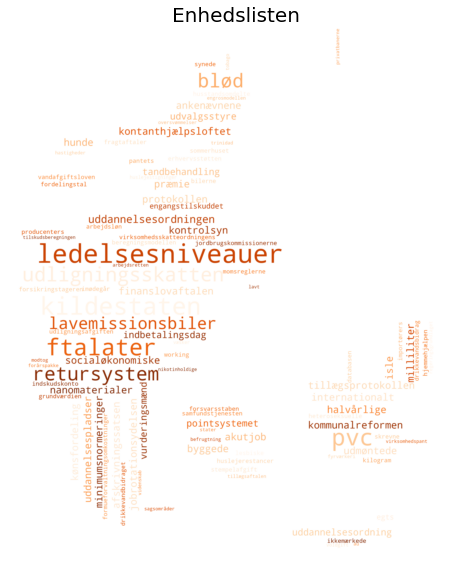

In [25]:
party = 'Enhedslisten'
create_wordcloud(subset_tf_idf[party], party, 'Oranges')

## Periods <a class="anchor" id="periods"></a>

We want to investigate what represents each parliament period through TF-IDF on the resume texts of the passed laws. First, we create a dictionary with all of the resume text and period id as key.

In [73]:
#Function that creates a dict with all the text in 'resume' summed for each unique key in the periode_id column
def get_text_for_period(law_text_list, period_id_list):
    #Create a dict with the period as key and the text as value
    period_text_dict = {}
    for law_text, period_id in zip(law_text_list, period_id_list):
        #If the period is not already in the dict, add it
        if period_id not in period_text_dict.keys():
            period_text_dict[period_id] = law_text
        else:
            period_text_dict[period_id] += law_text
    return period_text_dict

text_dict_period = get_text_for_period(list(df['resume']), list(df['periode_id']))
text_dict_period.keys()

dict_keys([32, 31, 30, 28, 35, 27, 138, 139, 144, 146, 26, 24, 25, 23, 22, 21, 20, 148, 150, 151, 153, 155])

Then we check if any of the periods are significantly shorter than others, to make sure not to scew the IDF score.

In [74]:
#print len of text in each period
for period in text_dict_period.keys():
    print(f'Period {period} has {len(text_dict_period[period])} characters')

Period 32 has 154126 characters
Period 31 has 178511 characters
Period 30 has 123461 characters
Period 28 has 152485 characters
Period 35 has 153005 characters
Period 27 has 167305 characters
Period 138 has 8784 characters
Period 139 has 157782 characters
Period 144 has 188503 characters
Period 146 has 214421 characters
Period 26 has 136858 characters
Period 24 has 994 characters
Period 25 has 128445 characters
Period 23 has 125831 characters
Period 22 has 148689 characters
Period 21 has 129437 characters
Period 20 has 65066 characters
Period 148 has 196245 characters
Period 150 has 649 characters
Period 151 has 126786 characters
Period 153 has 233030 characters
Period 155 has 192500 characters


Based on the results above, we will sort off Period 138, 24 and 150 as these are significantly shorter than the other periods.

In [75]:
# Sort off Period 138, 24 and 150
delete_periods = [138, 24, 150]

def sort_off_period(period_dict, periods_to_sort_off):
    for period in periods_to_sort_off:
        if period in period_dict.keys():
            del period_dict[period]

sort_off_period(text_dict_period, delete_periods)

We then calculate TF-IDF on the law texts from the remaining periods

In [76]:
tf_idf_period = law_text_to_tf_idf(text_dict_period)

To make the plots of the periods more understandable than just using the period id, (which doesn't explain much about the period) we create titles for the periods including the year(s) of the period.

In [77]:
# To make periods more understandable, extract and add the year to the title
def extract_year_from_periods(period_list):
    #extract the first 4 letters of the dato_sagstrin column (the year) and create a new column with this
    df['year'] = df['dato_sagstrin'].apply(lambda x: x[:4])

    #for each period in text_dict_period.keys() find the lowest and highest year in the df and create a dict with the period as key and the lowest and highest year as value
    period_year_dict = {}
    for period in period_list.keys():
        #find the lowest year in the df for each period
        lowest_year = df.loc[df['periode_id'] == period]['year'].min()
        #find the highest year in the df for each period
        highest_year = df.loc[df['periode_id'] == period]['year'].max()
        #add the lowest and highest year to the period_year_dict
        period_year_dict[period] = [lowest_year, highest_year]
    
    return period_year_dict

period_titles = extract_year_from_periods(text_dict_period)

Lastly, we plot the word clouds of the periods.

In [78]:
# Function to create word clouds for each period
def create_wordclouds(tf_idf_dict, dim, sub_plot_name, titles):

    fig, axs = plt.subplots(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    #fig.suptitle("Wordclouds of the parties", fontsize=16)

    for n, key in enumerate(tf_idf_dict.keys()):
        wordcloud = WordCloud(
                    max_font_size=50, 
                    max_words=30,
                    background_color ='white',
                    stopwords = stopwords_dk,
                    collocations=False,
                    ).generate_from_frequencies(tf_idf_dict[key])
        
        # Create a subplot of the wordcloud
        ax = plt.subplot(dim[0], dim[1], n+1)
        
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title(f'{sub_plot_name} {key} {titles[key][0]}-{titles[key][1]}', fontsize=20)

    fig.tight_layout()
    plt.show()

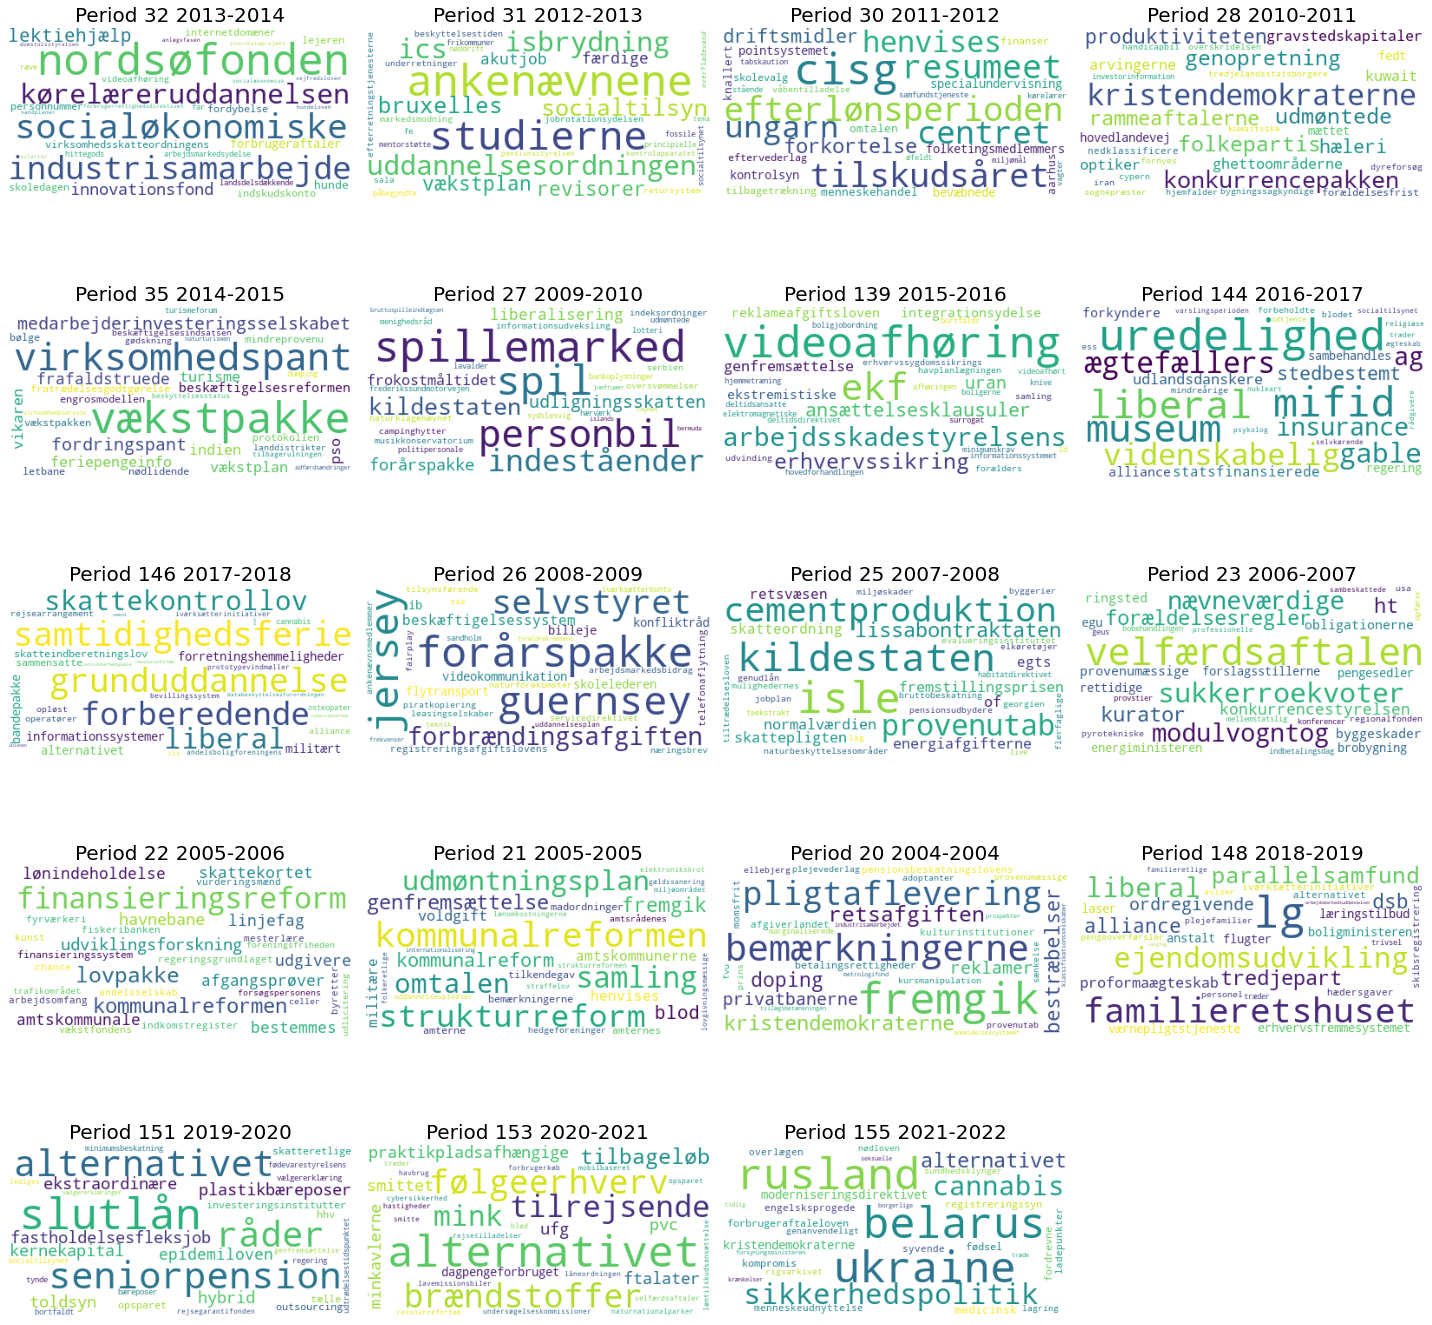

In [79]:
create_wordclouds(tf_idf_period, (5,4), 'Period', period_titles)

We plot only some of the periods of significance to show in the report

In [80]:
def create_wordcloud(tf_idf_dict, title):
    wordcloud = WordCloud(
                scale=5,
                mask=np.array(Image.open('denmark_map.png')),
                max_font_size=50, 
                max_words=100,
                stopwords = stopwords_dk,
                background_color="white",
                collocations=False,
                ).generate_from_frequencies(tf_idf_dict)
    
    # Display the generated image
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

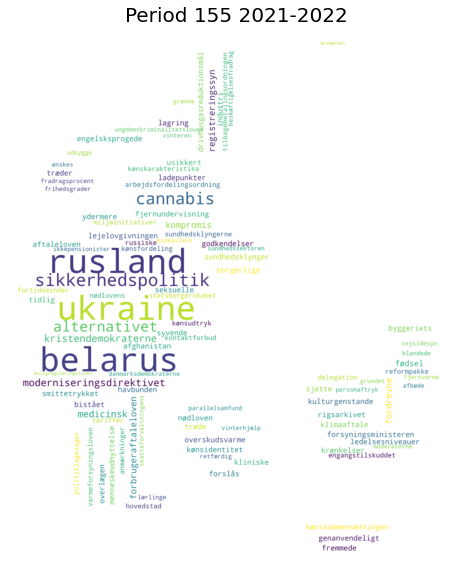

In [54]:
create_wordcloud(tf_idf_period[155], 'Period 155 2021-2022')

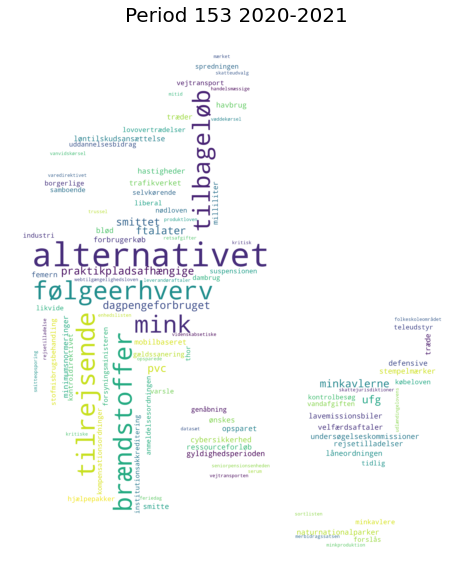

In [55]:
create_wordcloud(tf_idf_period[153], 'Period 153 2020-2021')